In [97]:
from ngsolve import *
import netgen.gui
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw

In [98]:
geo = SplineGeometry()
geo.AddRectangle( (0, 0), (2, 0.41), bcs = ("wall", "outlet", "wall", "inlet"))
geo.AddCircle ( (0.2, 0.2), r=0.05, leftdomain=0, rightdomain=1, bc="cyl")
mesh = Mesh( geo.GenerateMesh(maxh=0.08))
mesh.Curve(3);
# viscosity
nu = 0.001

In [99]:
k = 3
V = VectorH1(mesh,order=k, dirichlet="wall|cyl|inlet")
Q = H1(mesh,order=k-1)
X = V*Q

In [100]:
gfu = GridFunction(X)
velocity = gfu.components[0]
scene = Draw(velocity,mesh,"u")#,sd=3)
scene2 = Draw(gfu.components[1],mesh,"p")#,sd=3)
from ngsolve.internal import visoptions
visoptions.scalfunction = "u:0"

# parabolic inflow at bc=1:
uin = CoefficientFunction((1.5*4*y*(0.41-y)/(0.41*0.41),0))
gfu.components[0].Set(uin, definedon=mesh.Boundaries("inlet"))

scene.Redraw()
scene2.Redraw()

WebGuiWidget(value={'ngsolve_version': '6.2.2201', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': Fals…

WebGuiWidget(value={'ngsolve_version': '6.2.2201', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': Fals…

In [101]:
(u,p), (v,q) = X.TnT()

a = BilinearForm(X)
stokes = (nu*InnerProduct(grad(u),grad(v))-div(u)*q-div(v)*p)*dx
a += stokes
a.Assemble()

f = LinearForm(X)
f.Assemble()

inv_stokes = a.mat.Inverse(X.FreeDofs())

res = f.vec.CreateVector()
res.data = f.vec - a.mat*gfu.vec
gfu.vec.data += inv_stokes * res

scene.Redraw()
scene2.Redraw()

In [102]:
dt = 0.001
# matrix for implicit part of IMEX(1) scheme:
mstar = BilinearForm(X)
mstar += InnerProduct(u,v)*dx + dt*stokes
mstar.Assemble()
inv = mstar.mat.Inverse(X.FreeDofs())

conv = LinearForm(X)
conv += InnerProduct(grad(velocity)*velocity,v)*dx

In [103]:
t = 0
tend = 0
tend += 1
while t < tend-0.5*dt:
    print ("\rt=", t, end="")

    conv.Assemble()
    res.data = a.mat * gfu.vec + conv.vec
    gfu.vec.data -= dt * inv * res

    t = t + dt
    scene.Redraw()
    scene2.Redraw()

t= 0.9990000000000008760.01900000000000001 0.05200000000000004 0.79700000000000060.9040000000000007

In [24]:
# Supplementary 1

In [58]:
drag_x_test = GridFunction(X)
drag_x_test.components[0].Set(CoefficientFunction((-20.0,0)), definedon=mesh.Boundaries("cyl"))
drag_y_test = GridFunction(X)
drag_y_test.components[0].Set(CoefficientFunction((0,-20.0)), definedon=mesh.Boundaries("cyl"))

In [59]:
time_vals = []
drag_x_vals = []
drag_y_vals = []
# restoring initial data
res.data = f.vec - a.mat*gfu.vec
gfu.vec.data += inv_stokes * res

t = 0
tend = 0

In [60]:
# implicit Euler/explicit Euler splitting method:
tend += 1
while t < tend-0.5*dt:
    print ("\rt=", t, end="")

    conv.Assemble()
    res.data = a.mat * gfu.vec + conv.vec
    gfu.vec.data -= dt * inv * res

    t = t + dt
    scene.Redraw()
    scene2.Redraw()

    time_vals.append( t )
    drag_x_vals.append(InnerProduct(res, drag_x_test.vec) )
    drag_y_vals.append(InnerProduct(res, drag_y_test.vec) )
    #print(drag)

t= 0.999000000000000876 0.09300000000000007 0.2760000000000002 0.5660000000000004 0.6010000000000004 0.6370000000000005 0.6480000000000005 0.6620000000000005 0.8170000000000006 0.8650000000000007 0.9850000000000008

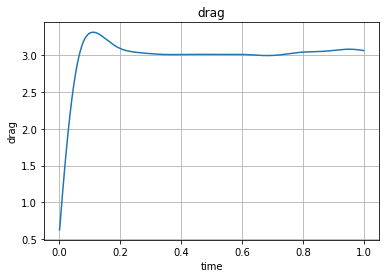

In [61]:
import matplotlib.pyplot as plt
# Plot drag force over time
plt.plot(time_vals, drag_x_vals)
plt.xlabel('time'); plt.ylabel('drag'); plt.title('drag'); plt.grid(True)
plt.show()

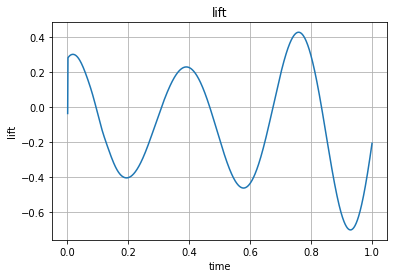

In [62]:
# Plot lift force over time
plt.plot(time_vals, drag_y_vals)
plt.xlabel('time'); plt.ylabel('lift'); plt.title('lift'); plt.grid(True)
plt.show()